---
# **Traditional vs Cloud: Geophysics with GeoLab**

### **Workflow with SAGE data**

This notebook walks you through a side-by-side comparison of traditional geophysical research workflows versus a modern, cloud-optimized approach using SAGE data via EarthScope’s GeoLab platform. By exploring a real-world waveform data analysis task in both paradigms, we illustrate key differences in speed, scalability, and user experience. GeoLab provides a unified, cloud-native environment where researchers can access open datasets, run compute-heavy routines, and share reproducible results—streamlining geophysical research from start to finish.

##### 🔹 **Why this matters?** 

Geophysics research is shifting. While traditional workflows have long supported foundational science, they often come with constraints like:
- Manual file downloads from FTP servers
- Limited local storage and processing capacity
- Time-consuming serial operations
- Barriers to sharing and reproducibility

Cloud-native platforms like **GeoLab**, combined with SAGE’s ARCO-optimized data in AWS S3, transform that experience:
- Immediate access to waveform datasets from the cloud
- Elastic computing resources that scale to your task
- Parallel data processing without manual overhead
- Built-in reproducibility for collaborative science

This notebook shows you the difference—in performance and usability—you can feel.

##### 🔹 **What you will do?** 

This notebook demonstrates both approaches using real-world seismic data from the Northern California Earthquake Data Center ([NCEDC](https://ncedc.org/index.html)), a partner archive in the SAGE data ecosystem.

1. **🚶 Traditional**: Download full files via FDSN web services using ObsPy.

2. **☁️ Cloud-Optimized**: Stream data objects directly from the NCEDC AWS Public Dataset via S3.

##### 🔹 **What you will learn?** 
By the end of this notebook, you’ll gain a practical understanding of:
- The advantages and limitations of local vs. cloud-based processing
- How SAGE’s ARCO-style data layout enhances discoverability and access
- How to use GeoLab to build fast, scalable, and reproducible workflows for waveform analysis

##### 🔹 **How to navigate throughout this notebook?**
- This notebook is structured to guide you through a comparative exploration of traditional versus cloud-optimized workflows for accessing and processing seismic waveform data.
- You’ll follow the same sequence of steps in both approaches—first retrieving waveform data related to a specific earthquake (a data mining task), then applying simple processing techniques to extract useful information. 
- Each section begins with a clear explanation of what you’re about to do and, more importantly, why it matters. These narratives are designed not only to orient you within the workflow but also to build your understanding of broader concepts like data access, scalability, and reproducibility. 
- At the end of each section, you’ll encounter a reflection prompt—a short question meant to encourage deeper thinking about the trade-offs, assumptions, or implications of the methods you’ve just applied.

As you move through the notebook, treat it not just as code to execute, but as a research story to engage with—one that sharpens your scientific thinking and equips you for modern, cloud-enabled geophysics.

Before diving into the notebook, you need to be familiar with
👉 [SAGE data archive](https://www.iris.edu/hq/sage) || 👉 [SAGE data products](https://ds.iris.edu/ds/nodes/dmc/data/)

---

## 1️⃣  **Traditional Workflow with ObsPy**

Let’s kick things off by working with real earthquake data! Our first task is to download **seismogram data** from a specific earthquake.

##### **Step 1: Choose an Earthquake**
For this exercise, we’ll focus on the [2022 Ferndale Earthquake](https://earthquake.usgs.gov/earthquakes/eventpage/nc73821036/executive), a magnitude 6.4 event that struck off the coast of Northern California. It's a great example because it has well-recorded data and is located near stations that contribute to the NCEDC archive.

💡 Feeling adventurous? You’re welcome to choose a different earthquake anywhere in the world. Just make sure the earthquake is close to seismic stations available in the [NCEDC cloud archive](https://ncedc.org/db/cloud.html), so you'll actually be able to find data for it. 

*Many other networks also offer data with direct S3 access. If you wish to work with data from a different network, you will need to adjust parameters like bucket name etc later in this exercise.*

☁️ Why This Matters? The real goal of this exercise is to show you how to access seismic data directly from the cloud—no downloads, no local storage. We’ll be using NCEDC’s public cloud storage as our data source.


##### **Step 2: Gather key Earthquake Details**
Before we can download seismograms, we need some essential information about the earthquake itself:
- Date and Time of the event
- Latitude and Longitude of the epicenter

These details are critical because they allow us to identify which seismic stations were close enough to record strong ground motion from the event. The closer the station, the better the data quality for analyzing the earthquake’s seismic energy. We’ll use this information to create an inventory of nearby stations with [ObsPy: get_stations](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_stations.html)

📥 Now, go ahead and enter the earthquake details into the code block below:

In [427]:
# Earthquake parameters (2022 Ferndale Earthquake)
event_time = "2022-12-20T10:34:24"  # UTC
event_lat  = 40.369
event_lon  = -124.588

##### **Step 3: Use ObsPy to Find Nearby Stations**

Now that we have the earthquake details, it’s time to use ObsPy to search for seismic stations near the event and visualize their locations.

In [ ]:
search_radius_km = 200  # You can adjust this as needed

# Import necessary libraries
import numpy as np
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import matplotlib.pyplot as plt
from obspy.clients.fdsn.header import URL_MAPPINGS

# set up start and end times for the search
start_time = UTCDateTime(event_time) - 10   # 10 seconds before the event
end_time = UTCDateTime(event_time) + 300    # 5 minutes after the event

# Set up the client for NCEDC
client = Client("IRIS")

# Get inventory of stations within the radius
inventory = client.get_stations(network='NC', latitude=event_lat, longitude=event_lon, maxradius=search_radius_km / 111.2,  # degrees ~km
                                starttime=start_time, endtime=end_time, channel='HNE', 
                                includeavailability=True, level="station")

# Visualize the station locations and the earthquake
print(f"Found {len(inventory[0].stations)} stations within {search_radius_km} km of the earthquake epicenter.")

Found 41 stations within 200 km of the earthquake epicenter.


##### **Step 4: Visualize the stations and earthquakes**

Let's visualize these stations around the earthquake. For that, first we will need the longitudes and latitudes of the stations.

Text(0.5, 1.0, 'Map of Seismic Stations and Earthquake Epicenter')

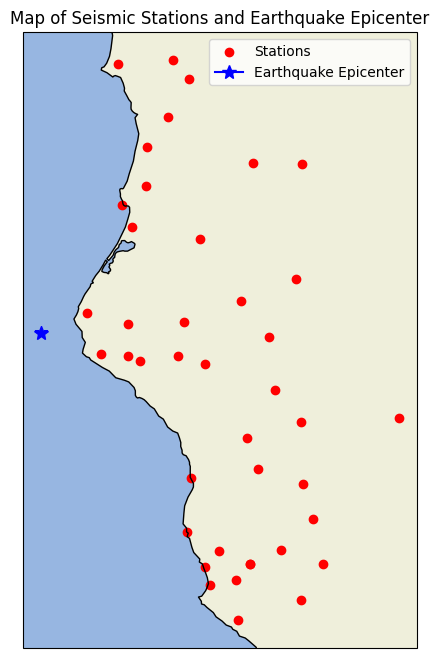

In [397]:
# Extract (latitude, longitude) tuples for each station in the inventory
st_latlon = [(station.latitude, station.longitude) for network in inventory for station in network.stations]

# Import necessary libraries for plotting and maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Create a figure and map with Plate Carrée projection (good for global or regional maps)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add basic geographic features for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Plot station locations if any are found
if st_latlon:
    lats, lons = zip(*st_latlon)
    ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='Stations')

# Plot the earthquake epicenter as a blue star
ax.plot(event_lon, event_lat, marker='*', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='Earthquake Epicenter')

# Add a legend and title
ax.legend()
ax.set_title("Map of Seismic Stations and Earthquake Epicenter")

> *⭕ **Reflection Question**: How did the combination of event metadata (e.g., origin time, epicenter coordinates) and station metadata (e.g., network code, channel availability, station locations) drive each step of your waveform retrieval and mapping process? Reflect on what might happen to your analysis if any piece of metadata were missing, ambiguous, or incorrect.*

##### **Step 5: Select a Station and Read Its Seismogram Using ObsPy**

Now, select one station from the inventory to and use obspy's [get waveform](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html) functionality to download and read its MiniSEED (mSEED) waveform data. In the code block below, assign a number between 1 and the maximum number of stations in your inventory. 

In the code block below, choose a station by assigning a number between 1 and the total number of stations available in your inventory. We'll use that number to extract the station's details and retrieve its corresponding seismogram.

📦 This is where the traditional data workflow begins—by downloading full waveform files directly from a data center.

NCEDC: Retrieved 1 traces
1 Trace(s) in Stream:
NC.GBL.01.HNE | 2022-12-20T10:34:14.000000Z - 2022-12-20T10:39:23.990000Z | 100.0 Hz, 31000 samples


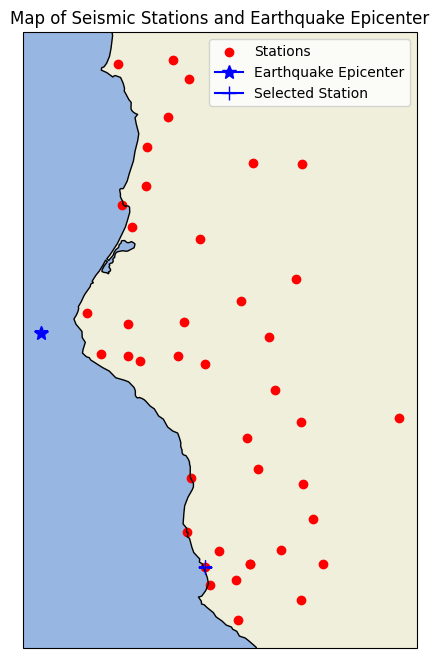

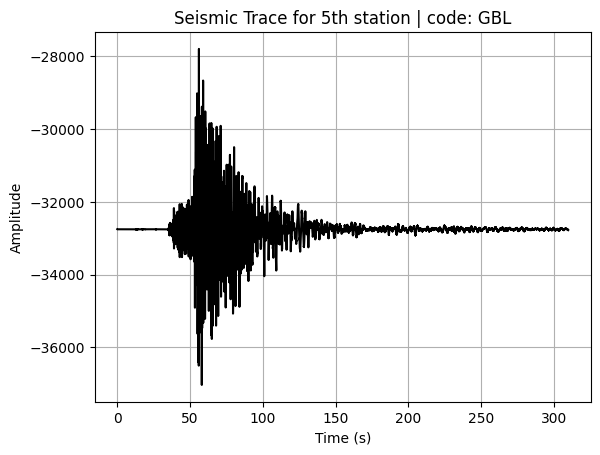

In [413]:
# select a station to retrieve data
selected_station_no = 5

# Select the station from the first network in the inventory
station_code = inventory[0].stations[selected_station_no-1].code
station_lon  = inventory[0].stations[selected_station_no-1].longitude
station_lat  = inventory[0].stations[selected_station_no-1].latitude

# loop through each repository
for provider in dict.fromkeys(['IRIS', 'NCEDC', 'SCEDC']):
    client = Client(provider)
    try:
        st = client.get_waveforms(network="NC", station=station_code, location="*",
                                  channel="HNE", starttime=start_time, endtime=end_time)
        if len(st) > 0:
            print(f"{provider}: Retrieved {len(st)} traces")
            print(st)
            break
    except:
        pass

# Create a figure and map with Plate Carrée projection (good for global or regional maps)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add basic geographic features for context
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='Stations')
ax.plot(event_lon, event_lat, color='blue', marker='*', markersize=10, transform=ccrs.PlateCarree(), label='Earthquake Epicenter')
ax.plot(station_lon, station_lat, color='blue', marker='+', markersize=10, transform=ccrs.PlateCarree(), label='Selected Station')

ax.legend()
ax.set_title('Map of Seismic Stations and Earthquake Epicenter')

tr = st[0] # Making it a trace object
time_sec = np.linspace(0, np.abs(tr.stats.starttime - tr.stats.endtime), len(tr.data)) # Create time vector in seconds

plt.figure()
plt.plot(time_sec, tr.data, color='black')
plt.title(f"Seismic Trace for {selected_station_no}th station | code: {station_code}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.show()


> *⭕ **Reflection Question**: Imagine you’re a seismic data detective: your metadata (network ID, station code, channel, time window) are the clues, and ObsPy is your multi-repository search engine (IRIS, NCEDC, SCEDC). How does each piece of metadata steer ObsPy toward the right archive and waveform? What might happen if your “clues” were mis-typed—say, an incorrect channel code—or if a repository didn’t have that station? Jot down strategies you could use to validate or enrich your metadata before fetching data, and how you’d handle a missing or mismatched waveform.*

##### **Step 6: Processing the Seismic Trace — From Raw Signal to Meaningful Insights**

Now that we've retrieved a seismic trace from one of the nearby stations, it's time to transform the raw waveform into a scientifically useful signal. This involves a few key preprocessing and analysis steps commonly used in observational seismology. Here's what we'll do next:

**Instrument Correction:** Seismic instruments don't record absolute ground motion directly—they record voltage signals that depend on the instrument’s response characteristics. So, our first step is to remove the instrument response from the raw trace. This correction gives us the signal in physical units (usually velocity or acceleration), which is essential for any quantitative analysis.

**P-wave arrival detection:** Next, we’ll use SeisBench, a powerful deep-learning toolkit for seismic phase picking, to automatically detect the P-wave arrival time. The P-wave (primary wave) is typically the first seismic signal to arrive, traveling fastest through the Earth. Identifying this arrival is critical because it marks the start of meaningful energy in the seismogram.

**Trim the trace:** Once we’ve identified the P-wave arrival, we’ll trim the trace, keeping only the portion of the signal that follows this arrival time. This ensures that we exclude background noise that was recorded before the earthquake waves reached the station, making our frequency and time-domain analyses more accurate.

**Frequency decomposition:** Finally, we’ll analyze the frequency content of the trimmed waveform using a Fast Fourier Transform (FFT). This mathematical tool transforms our signal from the time domain into the frequency domain, revealing what frequencies are present and how strongly they appear.

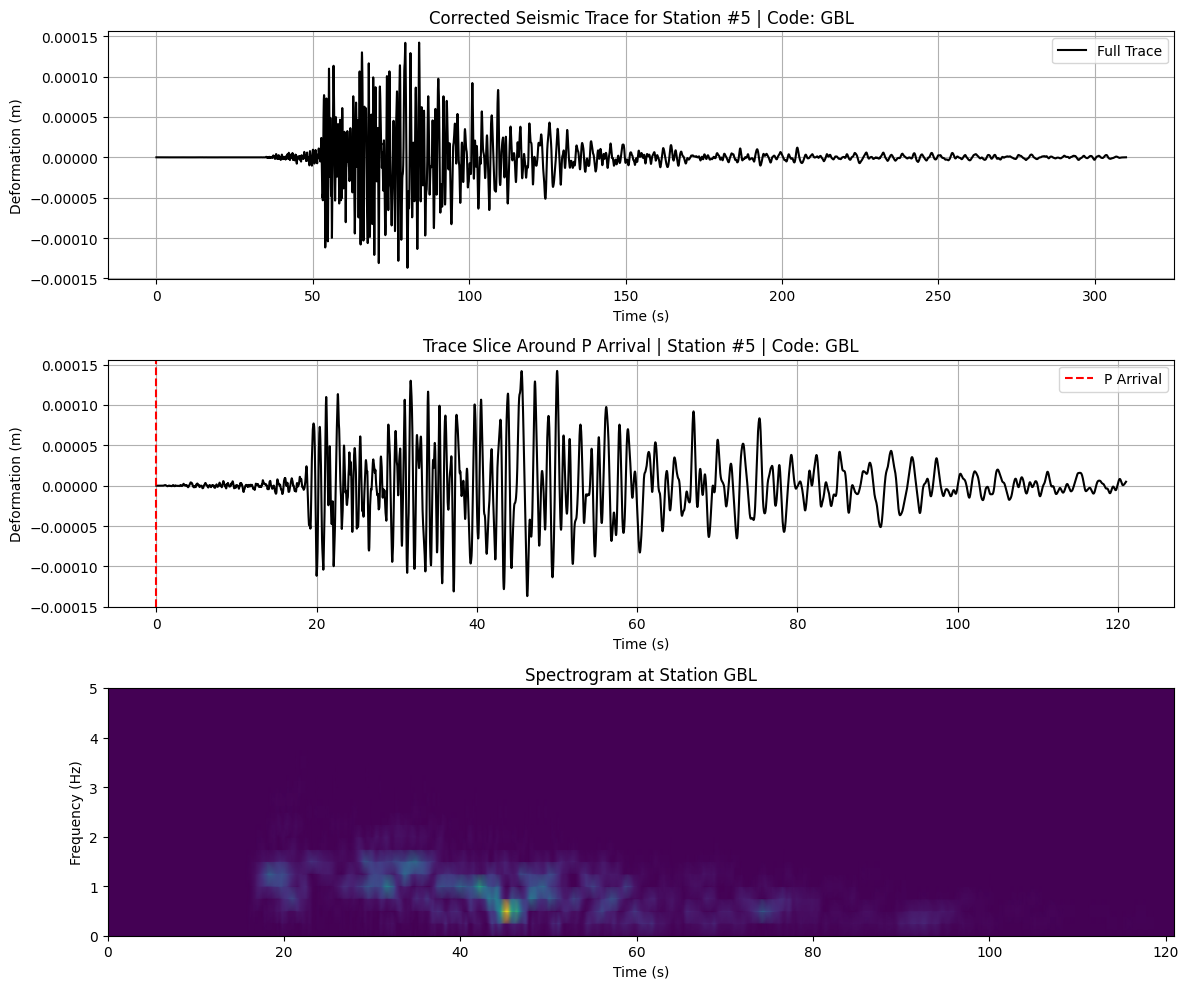

In [ ]:
# -------------------------------------------------------------------------------------
# Instrument Correction - Convert Raw Seismic Trace to Ground Displacement
# -------------------------------------------------------------------------------------

# Make a copy of the original trace to preserve raw data
tr_corrected = tr.copy()

# Remove the instrument response to convert counts to ground displacement (in meters)
# Options: "DISP" (displacement), "VEL", or "ACC"
tr_corrected.remove_response(inventory=inventory, output="DISP")

# -------------------------------------------------------------------------------------
# Phase Picking - Detect the P-wave Arrival Using SeisBench PhaseNet
# -------------------------------------------------------------------------------------

import seisbench.models as sbm  # Import model class from SeisBench

# Load the pretrained PhaseNet model (this will download if not cached locally)
picker = sbm.PhaseNet.from_pretrained("original")

# Use PhaseNet to pick seismic phases from the full stream (st)
# Adjust thresholds to control sensitivity of detection
picks = picker.classify(st, batch_size=256, P_threshold=0.075, S_threshold=0.1).picks

# Extract the time of the first detected P-wave (used to slice the trace)
p_time = picks[0].peak_time

# -------------------------------------------------------------------------------------
# Slice the Trace Around P-Wave Arrival to Focus on Useful Signal
# -------------------------------------------------------------------------------------

# Make a fresh copy of the corrected trace
tr_corr_slice = tr_corrected.copy()

# Slice 1 second before and 120 seconds after the P arrival
tr_corr_slice = tr_corr_slice.slice(starttime=p_time - 1, endtime=p_time + 120)

# Create time vector for the sliced trace
time_corr_sec = np.linspace(0, tr_corr_slice.stats.endtime - tr_corr_slice.stats.starttime, len(tr_corr_slice.data))

# -------------------------------------------------------------------------------------
# Frequency Analysis - Compute Spectrogram Using FFT
# -------------------------------------------------------------------------------------

from scipy import signal

# Sampling rate of the data
fs = tr_corr_slice.stats.sampling_rate

# Set window size and overlap for the spectrogram
nperseg = 400
noverlap = nperseg - 10

# Compute the spectrogram
f, t_spec, Sxx = signal.spectrogram(tr_corr_slice.data, fs=fs, nperseg=nperseg, noverlap=noverlap)

# Adjust spectrogram time axis to match slice duration
t_spec = np.linspace(0, time_corr_sec[-1], Sxx.shape[1])

# -------------------------------------------------------------------------------------
# Visualization - Raw Trace, Trimmed Slice, and Spectrogram
# -------------------------------------------------------------------------------------

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

# Plot 1: Full corrected trace
plt.subplot(3, 1, 1)
plt.plot(time_sec, tr_corrected.data, color='black')
plt.title(f"Corrected Seismic Trace for Station #{selected_station_no} | Code: {station_code}")
plt.xlabel("Time (s)")
plt.ylabel("Deformation (m)")
plt.grid()
plt.legend(["Full Trace"])

# Plot 2: Sliced trace around P-wave
plt.subplot(3, 1, 2)
plt.plot(time_corr_sec, tr_corr_slice.data, color='black')
plt.axvline(x=0, color='red', linestyle='--', label='P Arrival')
plt.title(f"Trace Slice Around P Arrival | Station #{selected_station_no} | Code: {station_code}")
plt.xlabel("Time (s)")
plt.ylabel("Deformation (m)")
plt.grid()
plt.legend()

# Plot 3: Spectrogram of the sliced trace
plt.subplot(3, 1, 3)
plt.pcolormesh(t_spec, f, np.abs(Sxx), shading='gouraud')
plt.xlim(0, time_corr_sec.max())
plt.ylim(0, 5)  # Limit frequency for readability
plt.title(f"Spectrogram at Station {station_code}")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")

plt.tight_layout()
plt.show()


> *⭕ **Reflection Question**: Which step—instrument correction, phase picking, trace slicing, or FFT—would seriously struggle with your laptop’s CPU if you are doing this for 200 stations, and how could moving that work to a cloud-native setup transform your workflow?*

##### **Wrapping It All Up — Creating a Reusable Seismogram Analysis Function**

Now that we've explored each step of the seismic data analysis workflow—from accessing data and correcting for instrument response, to picking P-wave arrivals and performing spectral analysis—it’s time to combine everything into a single, reusable function.

In practical, real-world research or production workflows, we rarely repeat steps manually for each dataset. Instead, we encapsulate our logic into functions or scripts that can be reused, scaled, and automated. That’s exactly what we’ll do here.

This function will take minimal input, such as:

- The time and location of the earthquake
- Optional parameters like analysis window or station radius

And in return, it will:

- Automatically access relevant seismic stations
- Download and process all available seismograms
- Apply instrument correction, pick P-waves, slice the traces, and generate spectrograms
- Visualize results for each trace

What makes this function especially powerful is that it supports both traditional and cloud-optimized workflows:

- The FDSN path follows the method you’ve used earlier: querying seismic data through centralized servers and downloading MiniSEED files.
- The cloud path taps directly into NCEDC’s public S3 storage on AWS, allowing us to stream waveform data on demand—no file downloads necessary.

Don't worry if the cloud portion of the function seems complex. It's perfectly okay to gloss over it for now! Just focus on understanding how the overall structure mirrors the steps we've already gone through manually. We'll go over the cloud-concepts later in this notebook.

The code block below contains the complete function. As you read through it:
- Look out for familiar steps: instrument correction, P-phase picking, slicing, and spectrogram generation.
- See how looping over multiple stations replaces the single-station analysis you did earlier.
- Notice how the function is modular, flexible, and ready to be reused for any future earthquake event with minimal setup.

By the end of this section, you’ll have a ready-to-use tool that not only reinforces everything you've learned so far, but also enables you to scale up your analysis in a clean, efficient, and professional way.

It’s completely okay if the code block above feels a bit overwhelming at first glance. What you’re looking at is a combination of three key functions working together:

- The main function analyzes seismograms from nearby stations after an earthquake.

- The two utility functions help filter stations by checking whether data for each station exists in both repositories — the FDSN service and NCEDC’s S3 archive.

But why is this filtering necessary? Because not all stations are available in both data sources. And since our goal is to compare data across these two storage systems, we must ensure we're analyzing the same set of stations from each.

To make the workflow clearer, take a look at the diagram below. It breaks down how these functions fit together and shows the step-by-step process behind the scenes.


<img src="function_workflow.png" alt="function_workflow.png" width="1200"/>


The following code block is long and has a lot of parts in it, so brace yourself 🙆‍♀️


In [ ]:
# ----------------------------------------------
# Import Required Libraries
# ----------------------------------------------
import os
import dask.delayed
import numpy as np
from obspy import UTCDateTime
from obspy import read
from obspy.clients.fdsn.client import Client
from obspy.core.inventory.inventory import Inventory
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import signal
import seisbench.models as sbm  # Import PhaseNet model from SeisBench
import boto3
from botocore import UNSIGNED
from botocore.config import Config
from botocore.exceptions import ClientError
import dask
from io import BytesIO

# ----------------------------------------------
# Configure S3 Client for Public NCEDC Access
# ----------------------------------------------
s3 = boto3.client('s3', config = Config(signature_version = UNSIGNED), region_name='us-west-2')
BUCKET_NAME = 'ncedc-pds'

# -------------------------------------------------------------------------
# 📌 Utility Function to check if data is available in repository
# -------------------------------------------------------------------------
def station_data_exists(station, eq_time, pre_time, post_time, client: Client, network: str, location: str, channel: str,
                        s3_client, bucket_name: str) -> bool:
    """
    Returns True only if:
     - FDSN.get_waveforms() delivers at least one trace in [eq_time-pre_time, eq_time+post_time]
     - There's an S3 object at the expected key for that day & station.
    """
    # 1) FDSN check
    start = eq_time - pre_time
    end   = eq_time + post_time
    try:
        st_temp = client.get_waveforms(network, station.code, location, channel, starttime=start, endtime=end)
        if len(st_temp) == 0:
            return False
    except Exception:
        return False

    # 2) S3 check — build the same key you use in your main function
    day0 = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    jul   = day0.julday
    fname = f"{station.code}.{network}.{channel}..D.{day0.year}.{jul:03d}"
    key   = f"continuous_waveforms/{network}/{day0.year}/" \
            f"{day0.year}.{jul:03d}/{fname}"
    try:
        s3_client.head_object(Bucket=bucket_name, Key=key)
    except ClientError:
        return False

    return True

# --------------------------------------------------------------
# 📌 Utility Function to Filter Inventory Based on Data Availability
# --------------------------------------------------------------
def filter_inventory(inventory: Inventory, eq_time, pre_time, post_time, client: Client, network: str, location: str, channel: str,
                     s3_client, bucket_name: str) -> Inventory:
    """
    Modify `inventory` in place so that each Network only keeps
    those Station objects for which `station_data_exists(...)` is True.
    Networks with zero stations are dropped.
    Returns the pruned Inventory.
    """
    # iterate all networks
    kept_networks = []
    for net in inventory.networks:
        kept_stns = []
        for st in net.stations:
            if station_data_exists(st, eq_time, pre_time, post_time, client, network, location, channel,
                                   s3_client, bucket_name):
                kept_stns.append(st)
        if kept_stns:
            net.stations = kept_stns
            kept_networks.append(net)

    inventory.networks = kept_networks
    return inventory

# ----------------------------------------------
# Load Pretrained Phase Picker (PhaseNet)
# ----------------------------------------------
picker = sbm.PhaseNet.from_pretrained("original")

# ----------------------------------------------
# 🧰 Main Function: Seismogram Analysis Workflow
# ----------------------------------------------
def analyze_earthquake(eq_time, eq_lon, eq_lat, radius_km, data_source='fdsn',
                       client_name='NCEDC', network='NC', location='*', channel='HHZ',
                       pre_time=3, post_time=120, output_dir='plots'):
    """
    Analyze seismic waveforms from stations near an earthquake using FDSN or cloud-based access.

    This function performs data fetching, instrument correction, P-phase picking,
    waveform slicing, and spectrogram plotting in a scalable way.

    Parameters:
    ------------
    eq_time : str or obspy.UTCDateTime
        Earthquake origin time (ISO string like '2022-12-20T10:34:24' or UTCDateTime).
    eq_lon : float
        Earthquake longitude in decimal degrees.
    eq_lat : float
        Earthquake latitude in decimal degrees.
    radius_km : float
        Search radius around epicenter in kilometers.
    data_source : str, optional
        Data source for waveforms ('fdsn' or 'S3', default 'fdsn').
    client_name : str, optional
        Seismic data client (default 'NCEDC').
    network : str, optional
        Seismic network code (default 'NC').
    location : str, optional
        Station location code wildcard (default '*').
    channel : str, optional
        Channel code (default 'HHZ').
    pre_time : float, optional
        Seconds before eq_time to start waveform window (default 10 s).
    post_time : float, optional
        Seconds after eq_time to end waveform window (default 200 s).
    output_dir : str, optional
        Directory to save plots (default 'plots').

    Requirements:
    -------------
    - SeisBench PhaseNet picker pre-loaded above.
    - Necessary packages installed: obspy, boto3, utm, numpy, matplotlib, cartopy, scipy, seisbench.

    """
    # Ensure eq_time is UTCDateTime
    if not isinstance(eq_time, UTCDateTime):
        eq_time = UTCDateTime(eq_time)

    # Define waveform time window
    start_time = eq_time.replace(hour=0, minute=0, second=0, microsecond=0)
    end_time = eq_time.replace(hour=23, minute=59, second=59, microsecond=999999)

    # Create output directory if it doesn't exist
    os.makedirs(f"{output_dir}/{data_source}", exist_ok=True)

    # ----------------------------------------------
    # Step 1️⃣: Retrieve Station Metadata
    # ----------------------------------------------
    client = Client(client_name)
    print("Making inventory of stations ...")
    inventory = client.get_stations(network=network, latitude=eq_lat, longitude=eq_lon,
                                    starttime=start_time, endtime=end_time, maxradius=radius_km/111.2, # Convert km to degrees
                                    location=location, channel=channel, level="response")
    
    print("Filtering the inventory ...")
    inventory = filter_inventory(inventory, eq_time, pre_time, post_time, client, network, location, channel, s3, BUCKET_NAME)

    stations = inventory[0].stations
    print(f"Found {len(stations)} stations within {radius_km} km of ({eq_lat}, {eq_lon}).")

    # ----------------------------------------------
    # Step 2️⃣: Plot Station Locations on a Map
    # ----------------------------------------------
    st_latlon = [(station.latitude, station.longitude) for network in inventory for station in network.stations]
    
    # Create a plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Add geographic features
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Plot the stations
    if st_latlon:
        lats, lons = zip(*st_latlon)
        ax.scatter(lons, lats, color='red', marker='o', transform=ccrs.PlateCarree(), label='PNSN Stations')

    ax.plot(eq_lon, eq_lat, marker='*', color='blue', markersize=10, transform=ccrs.PlateCarree(), label='Earthquake Epicenter')
    
    out_file = os.path.join(output_dir, f"st_event.png")
    fig.savefig(out_file, dpi=300, bbox_inches='tight')
    
    # Loop Over Each Station
    for st in stations:
        station_code = st.code
        try:
    # -----------------------------------------------------------
    # Step 3️⃣: # Download waveforms & apply instrument correction
    # -----------------------------------------------------------
            if data_source == 'fdsn':
                st_stream = client.get_waveforms(network=network, station=station_code, location=location,
                                                 channel=channel, starttime=start_time, endtime=end_time)
                if len(st_stream) > 0:
                    st_stream.merge(method=1, fill_value='interpolate')

                st_stream.trim(starttime=eq_time - pre_time, endtime=eq_time + post_time)
                
            elif data_source == 'S3':
                file_name = f'{station_code}.{network}.{channel}..D.{start_time.year}.{start_time.julday:03d}'
                KEY = f"continuous_waveforms/{network}/{start_time.year}/{start_time.year}.{start_time.julday:03d}/{file_name}"

                # stream the object from S3 and wrap in a BytesIO
                resp = s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
                data_stream = resp['Body']              # this is a file-like StreamingBody
                buff = BytesIO(data_stream.read())      # read all bytes into an in-memory buffer
                buff.seek(0)                            # rewind to the front
                
                # now read directly from that buffer
                st_stream = read(buff, format='MSEED')
                st_stream.trim(starttime=eq_time - pre_time, endtime=eq_time + post_time)

            print(f"- Downloaded {len(st_stream)} traces for station {station_code}.")
        except Exception as err:
            print(f"- Failed to download waveforms for station {station_code}: {err}")
            continue

        # Skip if no data
        if len(st_stream) == 0:
            continue

        # Assuming single trace per station
        tr = st_stream[0]

        # Remove the instrument response to convert counts to ground displacement (in meters)
        tr.remove_response(inventory=inventory, output="DISP")

    # ----------------------------------------------
    # Step 4️⃣: Pick P-wave Arrivals & Slice Waveform
    # ----------------------------------------------
        picks = picker.classify(st_stream, batch_size=256, P_threshold=0.075, S_threshold=0.1).picks
        if not picks:
            print(f"- No picks found for station {station_code}.")
            continue

        # Use first P arrival time for plotting
        p_time = picks[0].peak_time

        # Slice trace around P arrival
        tr = tr.slice(starttime=p_time - pre_time, endtime=p_time + post_time)
        times = np.linspace(0, (p_time + post_time) - (p_time - pre_time), len(tr.data))

    # ----------------------------------------------
    # Step 5️⃣: Compute Spectrogram
    # ----------------------------------------------
        fs = tr.stats.sampling_rate # Sampling rate of the trace
        nperseg = 400               # Window size for the spectrogram
        f, t_spec, Sxx = signal.spectrogram( tr.data, fs=fs, nperseg=nperseg, noverlap=nperseg - 10)
        t_spec = np.linspace(0, (p_time + post_time) - (p_time - pre_time), Sxx.shape[1])

        # Plot waveform and spectrogram
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(times, tr.data, linewidth=0.5)
        ax1.set_xlim(0, times.max())
        ax1.set_title(f"Waveform at {station_code}")
        ax1.set_xlabel("Time (s)")
        ax1.set_ylabel("Deformation (m)")

        ax2 = fig.add_subplot(2, 1, 2)
        pcm = ax2.pcolormesh(t_spec, f, np.abs(Sxx), shading='gouraud')
        ax2.set_xlim(0, times.max())
        ax2.set_ylim(0, 5)  # Limit frequency for readability
        ax2.set_title(f"Spectrogram at {station_code}")
        ax2.set_xlabel("Time (s)")
        ax2.set_ylabel("Frequency (Hz)")
        fig.tight_layout()

        # Save plot
        timestamp = eq_time.strftime("%Y%m%dT%H%M%SZ")
        out_file = os.path.join(f"{output_dir}/{data_source}/{station_code}_{timestamp}_{data_source}.png")
        fig.savefig(out_file, dpi=300, bbox_inches='tight')
        plt.close(fig)
        print(f"-- Saved plot to {out_file}")

Now, we are going to input the time, location and search radius for an earthquake and let the function do its work. It is going to plot the spectrograms in `plots/fdsn/` directory.

Making inventory of stations ...
Filtering the inventory ...
Found 72 stations within 500 km of (40.369, -124.588).
- Downloaded 1 traces for station AFD.
-- Saved plot to plots/fdsn/AFD_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station BSR.
- No picks found for station BSR.
- Downloaded 1 traces for station CADB.
- No picks found for station CADB.
- Downloaded 1 traces for station CAG.
-- Saved plot to plots/fdsn/CAG_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station CBP.
-- Saved plot to plots/fdsn/CBP_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station CBR.
-- Saved plot to plots/fdsn/CBR_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station CCOB.
- No picks found for station CCOB.
- Downloaded 1 traces for station CGP.
-- Saved plot to plots/fdsn/CGP_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station CLCB.
-- Saved plot to plots/fdsn/CLCB_20221220T103424Z_fdsn.png
- Downloaded 1 traces for station CMM.
- No picks found for station CMM.
- Do

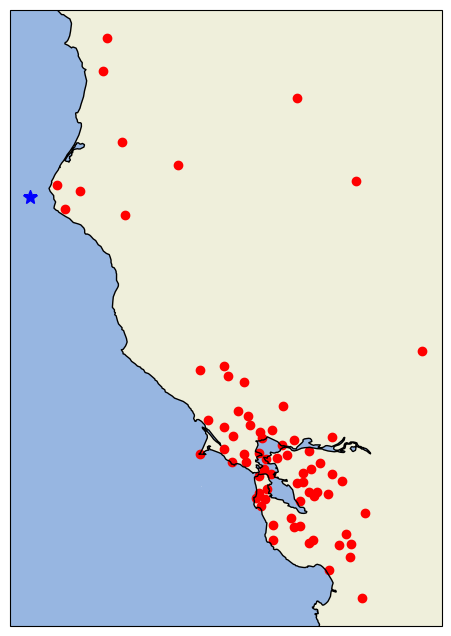

In [550]:
# Earthquake parameters (2022 Ferndale Earthquake)
event_time = "2022-12-20T10:34:24"  # UTC
event_lat  = 40.369
event_lon  = -124.588

search_radius_km = 250  # You can adjust this as needed

analyze_earthquake(event_time, event_lon, event_lat, radius_km=search_radius_km, data_source='fdsn', channel='HNE')

Now, we are going to input the same earthquake parameters, but will retrieve the data from S3 bucket. The spectrograms should be in `plots/S3/` directory

Found 12 stations within 250 km of (40.369, -124.588).
- Downloaded 1 traces for station GAXB.
-- Saved plot to plots/S3/GAXB_20221220T103424Z_S3.png
- Downloaded 1 traces for station GCVB.
-- Saved plot to plots/S3/GCVB_20221220T103424Z_S3.png
- Downloaded 1 traces for station GDXB.
-- Saved plot to plots/S3/GDXB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KCO.
-- Saved plot to plots/S3/KCO_20221220T103424Z_S3.png
- Downloaded 1 traces for station KCT.
-- Saved plot to plots/S3/KCT_20221220T103424Z_S3.png
- Downloaded 1 traces for station KHBB.
-- Saved plot to plots/S3/KHBB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KHMB.
-- Saved plot to plots/S3/KHMB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KMPB.
-- Saved plot to plots/S3/KMPB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KMR.
-- Saved plot to plots/S3/KMR_20221220T103424Z_S3.png
- Downloaded 1 traces for station KRMB.
-- Saved plot to plots/S3/KRMB_20221220T103424Z_S3.png
-

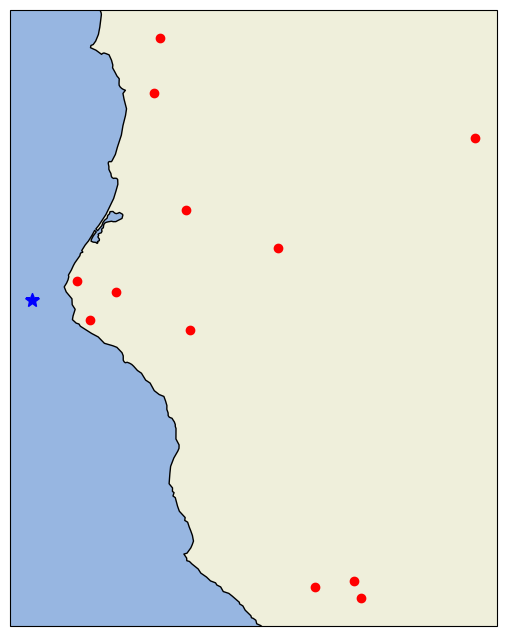

In [540]:
analyze_earthquake(event_time, event_lon, event_lat, radius_km=search_radius_km, data_source='S3', channel='HNE')

---

Now, we are going to learn how you accessed the data from the S3 bucket over the cloud.

## 2️⃣ **Cloud Optimized Workflow**

Now, let’s walk through the same workflow—but this time, we’ll be pulling the data from Amazon AWS in the cloud. There are some clear perks to working with data this way. Cloud platforms are built to give you the speed, flexibility, and scalability that today’s research really needs. Instead of being limited by your laptop or a local server, you can quickly spin up powerful computing and storage resources whenever you need them, scale things up or down easily, and only pay for what you actually use.

Here’s a breakdown of the key building blocks in a cloud-optimized setup:

- **Compute Power**: With [Amazon EC2](https://docs.aws.amazon.com/AWSEC2/latest/UserGuide/concepts.html) (Elastic Compute Cloud), you get access to virtual machines that function just like remote high-performance computers. Whether you're running Python scripts to pick seismic phases, processing waveforms, or testing automated detection algorithms, EC2 lets you scale your compute resources — more CPUs, more memory, or even GPUs — whenever you need them. It’s like upgrading your laptop on demand.

- **Data Storage**: [Amazon S3](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html) (Simple Storage Service) gives you flexible, object-based storage that’s perfect for seismic datasets. You can store miniSEED files, raw waveform archives, event catalogs, and more — all inside organized “buckets” with features like version control, compression, and tagging. It’s optimized for fast, parallel access from anywhere, which makes it ideal for cloud-based seismic analysis.

- **Scalable Clusters**: Tackling big jobs — like running noise cross-correlation across thousands of station pairs or scanning terabytes of continuous seismic data for events — calls for serious horsepower. That’s where clusters come in. Using tools like AWS Batch, Kubernetes, or even serverless options, you can launch a whole fleet of machines that work together to crunch through the workload. The best part? You can process massive volumes of data in a fraction of the time it would take on a single system.

All of these resources scale up/down in minutes, so you pay only for what you use. 


<img src="https://assets.community.aws/a/2YnihCpaNZkmFVuxyHKWrcxDSMT.png?imgSize=919x516" alt="awsEC2" width="320"/> 
<img src="https://i.ytimg.com/vi/ecv-19sYL3w/mqdefault.jpg" alt="awsS3" width="320"/> <img src="https://d2908q01vomqb2.cloudfront.net/b6692ea5df920cad691c20319a6fffd7a4a766b8/2022/06/09/Image-1a-VPC.png" alt="awsS3" width="315"/> 

Now, let’s take your step-by-step GeoLab workflow and translate it into cloud-native terms, using core services like EC2 (compute), S3 (storage), and clusters (parallelism & scaling). This helps reveal how cloud resources are invisibly powering the tasks you're doing in the notebook.

**Launch a server on GeoLab**: GeoLab lets you spin up a virtual server in the cloud, powered by Amazon EC2. Think of it as renting a high-performance computer that lives in a data center — but with the flexibility to configure it exactly the way you want.

- You can choose the amount of memory, CPU power, and storage based on your needs.
- While GeoLab handles the setup behind the scenes, it's actually launching an EC2 instance under the hood that matches your selected specs.
- EC2 is designed to be elastic -- meaning resources will automatically scale up or down as your workload changes. Depending on your chosen server configuration, 'Extra' compute resources on your instance may be shared with other users to maximize resource utilization efficiency and minimize compute costs.

**Open Jupyter + Download miniSEED Files**:  Once your server is running, you can launch a Jupyter Notebook right from your browser and begin working with seismic data.

- When you download waveform data (e.g., miniSEED files) from cloud-hosted repositories, you're often pulling that data directly from Amazon S3 — Amazon’s object storage system.
- Each miniSEED file is stored as an object in an S3 bucket, complete with metadata like station code, channel, and time range.
- Downloading it is just like grabbing a neatly packaged file from the cloud and bringing it into your EC2 instance for analysis.

**Analyze and Plot → Compute + Optional Cluster Mode**: Now that the waveform data is local to your virtual machine, you can process it just like you would on your laptop — only faster and more scalable.

- For smaller tasks, like filtering or plotting data from a few stations, a single EC2 instance works great.
- For larger-scale processing — say, running STA/LTA detection across thousands of stations or cross-correlation workflows — you can scale up by launching a compute cluster.
- Clusters consist of multiple EC2 instances working together, coordinated via tools like AWS Batch, Dask, or other distributed frameworks to handle big jobs efficiently.

<img src="aws_workflow_sage.png" alt="aws_workflow.png" width="500"/>

*Because many networks and organizations (like Earthscope, NCEDC) are using object storage in AWS S3, even if you do not intend to use it for your own storage, you will most likely interact with cloud-hosted data at some point in the future.*

---





### **1. Cloud storage: objects vs local files**

Cloud storage isn’t just about “uploading files to the internet” — it represents a whole new way of organizing, accessing, and thinking about data.

Services like Amazon S3 use what’s called object storage. Unlike traditional file systems, object storage treats each file as an independent, self-contained object — bundling together the raw data, descriptive metadata, and a unique identifier.

Here’s a quick breakdown:

🔷 Bucket: Think of this as your personal storage space — like the top-level directory in a filesystem, but without rigid folder structures. It’s a flat namespace where all your objects live.

🔷 Object: The heart of the system. An object contains:

- The actual data (your file contents)
- Metadata (like timestamps, content type, or custom tags)
- A unique key (its full “name” or address within the bucket)

Each object is self-sufficient — there are no folders or parent-child dependencies. And the object key is for human readability and doesn't have any implications for the machine. The key is essentially a human-friendly name—just a string the service uses to look up a blob. Machines don’t “understand” or optimize based on the key’s meaning; they treat it as an opaque identifier, not a schema or directory. Slashes in keys don’t create real folders, and the key’s wording doesn’t affect how the data is stored or retrieved (beyond simple string-prefix features like listing, lifecycle rules, or access policies you define). Good key design helps you with organization and discoverability; it doesn’t give the system extra hints about performance or semantics.

🔷 File: A file only exists on your local system when you download or write an object. Until then, it’s just an object in the cloud.

In short: when you upload to S3, you’re storing a data+metadata package (an object) inside a named bucket, and referencing it with a unique key. This structure makes cloud data highly scalable, searchable, and accessible — ideal for modern, distributed workflows.

***Traditional storage vs Object Storage⤵️***

 <img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*VsX-1XW2EVYCwz2IRH_2FQ.png" alt="cloudStorage" width="500"/> 


> *⭕ Reflection Question: How could adopting object storage reshape the way you design, scale, or automate data-intensive workflows — especially in projects where flexibility, traceability, and interoperability are key?*

In the function `analyze_earthquake` that we defined before we downloaded data from [NCEDC's S3 open bucket](https://ncedc.org/db/cloud.html). It is your time to revisit the function and investigate the code lines where we accessed the S3 bucket. At the very beginning we first configure the NCEDC's S3 client for public access. For that we used `boto3`.

Think of `boto3` as your personal cloud gatekeeper — it opens the door to AWS securely and reliably. It simplifies the use of AWS services by providing a set of libraries that are consistent and familiar for Python developers.

- Load your AWS credentials from a config file or environment variable
- Create authenticated sessions that other libraries can use
- Interact with AWS services in a Pythonic way — no low-level REST calls

It handles all the gritty details of signing requests, managing credentials, and retrying fallen network calls, so you can focus on your data rather than on AWS plumbing.

To simply put `boto3` is a collection of classes, code, helpers, scripts, aka [SDK](https://en.wikipedia.org/wiki/Software_development_kit) that calls AWS [APIs](https://en.wikipedia.org/wiki/API) for you. You may need to add authentication through `boto3` for other datasets that may require it.

To learn more  👉  [Boto3](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html)

In [1]:
# Import boto3 library
import boto3
from botocore import UNSIGNED
from botocore.config import Config

# ----------------------------------------------
# Configure S3 Client for Public NCEDC Access
# ----------------------------------------------

# Define configuration for accessing the NCEDC Public S3 Bucket
# This tells boto3 not to sign requests (since it's a public bucket)
ncedc_config = Config(signature_version=UNSIGNED)

# Create an S3 client using the config
# Region 'us-west-2' is where the NCEDC bucket is hosted
s3 = boto3.client('s3', config = ncedc_config, region_name='us-west-2')

# Define the bucket name (constant for NCEDC)
BUCKET_NAME = 'ncedc-pds'


---

### **2. ARCO-style data concept**

Now that you've seen where your files are stored in the cloud, let's talk about how they're stored — because how you store data directly affects *how fast* and *how well* you can use it.

This is where the **ARCO** concept comes into play:

**Analysis-Ready, Cloud-Optimized.**

- **Analysis-Ready** means the data is organized in a way that promotes immediate use — it’s clean, structured, and self-describing, making it easy to analyze or combine with other datasets without needing complex pre-processing.

- **Cloud-Optimized** means the data is stored in a format that takes full advantage of the cloud: it's designed for fast, scalable, and parallel access — ideal for modern data workflows.

In short, ARCO ensures that your data isn’t just in the cloud — it’s ready to go the moment you need it.

In ARCO storage design, each data object is immutable and self descriptive. Objects are addressed by a `bucket + key` combination and always carry associated metadata (e.g., upload timestamp, tags, or user-defined metadata such as station name or observation type). This model supports robust indexing, reproducibility, and easy parallel access.

The following code block below demonstrates how ARCO-style data principles apply in the context of downloading GNSS observation data. Two key ideas are central:

- **Immutable time-sliced objects:** Data is downloaded or referenced using a precise time window — usually in ISO 8601 format.

- **Self-describing metadata:** Observation parameters such as constellation and GNSS observation codes are explicitly defined and embedded, allowing clients to handle data without needing external schema lookups.

The data in the `ncedc-pds` bucket is structured in a predictable and systematic way, making it easier to programmatically browse and access seismological waveform data. Here's what you need to know:

**Folder structure (Key Prefixes)**

At the top level, you will find a directory named: `continuous_waveforms/`

Under this directory files are organized by:

- Network Code – The seismic network identifier (e.g., `CI`, `NC`, etc.)
- Year – A 4-digit year (e.g., `2024`)
- Day of Year (DOY) – A 3-digit number from `001` to `366` representing the Julian day

So the full path (or object key) to any given file looks like:

`continuous_waveforms/Network_Code/YYYY/YYYY.DOY/FILE_NAME`

**File details**
- Each file represents one full day of continuous waveform data starting at 00:00:00 UTC
- Files are typically in MiniSEED format, commonly used for time series data in seismology

Each file follows this structure:
`[Station].[Network].[Channel]..D.[Year].[DayOfYear]`

Example filename: `CMB.NC.BHZ..D.2024.067`
Where:
- `CMB` = Station code
- `NC` = Network code
- `BHZ` = Channel code
- `D` = Denotes daily data
- `2024` = Year
- `067` = Day of year (Julian date)

In [13]:
# Import libraries
from obspy import UTCDateTime
from io import BytesIO

# Define target seismic station info
station_code = 'GAXB' # you can put any name from the station list that you gathered waveforms for using function 'analyze_earthquake'
network = 'NC'
channel = 'HNE'

# Define event parameters (Ferndale Earthquake - Dec 20, 2022)
event_time = UTCDateTime("2022-12-20T10:34:24")  # UTC timestamp

# Construct the filename using the MiniSEED naming convention
# Format: [Station].[Network].[Channel]..D.[Year].[DOY]
file_name = f"{station_code}.{network}.{channel}..D.{event_time.year}.{event_time.julday:03d}"

# Construct the full object key (path) to the file in S3
KEY = (
    f"continuous_waveforms/{network}/"
    f"{event_time.year}/{event_time.year}.{event_time.julday:03d}/{file_name}"
)

---

### **3. Object read (streaming)**
Welcome to one of the most powerful benefits of cloud-optimized data: streaming directly from object storage.

Unlike traditional workflows where files must be downloaded in full, streaming allows you to:

- Open the data objects remotely on S3
- Stream only the data slice you need, directly into memory
- Avoid local storage entirely — nothing is written to disk
- Work in real time, ideal for scalable, parallel pipelines

This is a complete reversal of the "download-then-analyze" mindset. Instead, think: "slice-on-the-fly" and "analyze-while-streaming".

In [14]:
# Stream the object from S3 using unsigned public access
resp = s3.get_object(Bucket=BUCKET_NAME, Key=KEY)
data_stream = resp['Body']                      # StreamingBody from S3
buff = BytesIO(data_stream.read())              # Convert to in-memory byte buffer
buff.seek(0)                                    # Rewind to the beginning

# Read waveform data directly from the byte buffer using ObsPy
st_stream = read(buff, format='MSEED')
st_stream.trim(starttime=event_time, endtime=event_time + 120)  # extract 2 minutes of data

# Output the trace for verification
print(st_stream)

1 Trace(s) in Stream:
NC.GAXB..HNE | 2022-12-20T10:34:24.000000Z - 2022-12-20T10:36:24.000000Z | 100.0 Hz, 12001 samples


> *⭕ Reflection Question: In a traditional workflow, processing a huge dataset (e.g., 10,000 seismograms) usually means downloading and storing it locally for repeated analysis. In a cloud-optimized workflow, would you still need to download the data—or could you bring the computation to the data instead? Explain your reasoning.*

Now, we are going to compare the processing time if we retrieve the data from in a traditional way vs the cloud native way


🔄 Running analysis using data_source = 'S3'
Making inventory of stations ...
Filtering the inventory ...
Found 7 stations within 150 km of (40.369, -124.588).
- Downloaded 1 traces for station KCO.
-- Saved plot to plots/S3/KCO_20221220T103424Z_S3.png
- Downloaded 1 traces for station KCT.
-- Saved plot to plots/S3/KCT_20221220T103424Z_S3.png
- Downloaded 1 traces for station KHBB.
-- Saved plot to plots/S3/KHBB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KHMB.
-- Saved plot to plots/S3/KHMB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KMPB.
-- Saved plot to plots/S3/KMPB_20221220T103424Z_S3.png
- Downloaded 1 traces for station KMR.
-- Saved plot to plots/S3/KMR_20221220T103424Z_S3.png
- Downloaded 1 traces for station KRMB.
-- Saved plot to plots/S3/KRMB_20221220T103424Z_S3.png
⏱  'S3' run completed in 33.71 seconds

🔄 Running analysis using data_source = 'fdsn'
Making inventory of stations ...
Filtering the inventory ...
Found 7 stations within 150 km of 

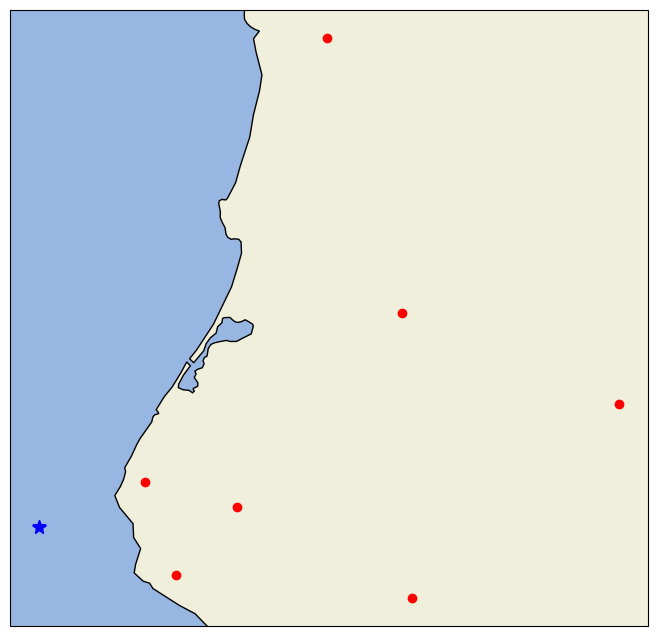

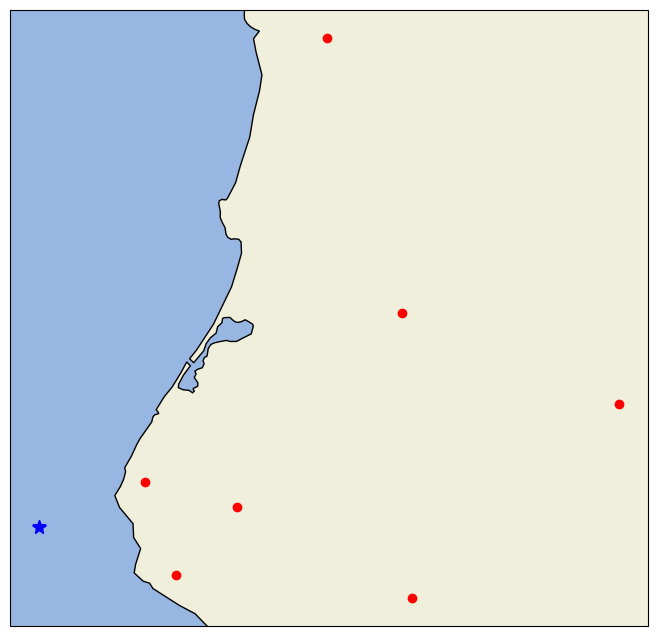

In [19]:
import time

# Define common parameters
params = {
    'eq_time': event_time,
    'eq_lon':  event_lon,
    'eq_lat':  event_lat,
    'radius_km':  150,
    'channel':    'HNE'
}

# Loop over both data sources and time them
for source in ['S3', 'fdsn']:
    print(f"\n🔄 Running analysis using data_source = '{source}'")
    start = time.perf_counter()
    
    # Run the analysis
    analyze_earthquake(**params, data_source=source)
    
    elapsed = time.perf_counter() - start
    print(f"⏱  {source!r} run completed in {elapsed:.2f} seconds")

When you run this analysis on [GeoLab](https://www.earthscope.org/data/geolab/), EarthScope’s cloud-native infrastructure, data access and processing via S3 is noticeably faster than pulling from an FDSN server. In our tests with seven stations, the cloud workflow finished about 10 seconds sooner.

> *⭕ **Reflection Question:** Why do you think the cloud-based workflow on GeoLab was faster than using the FDSN server? What specific advantages of cloud-optimized data access and processing might be enabling this speedup—and how could that impact the way you design larger-scale analyses?*